# Higher-performance computing

There are various ways to speed up the execution of code in a Jupyter notebook

- Numba
- Fortran magic
- Cython

## Numba

Numpy offers fast vector computations of arrays, but some algorithms can't be vectorized and require explicit loops.

However, Python loops are slow. *Numba* can speed up Python through a just-in-time (JIT) compiler, compiling Python code directly to machine code. 

### Numba example: random walk

First without Numba

In [5]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [7]:
def step():
    return 1. if random.random() > .5 else -1.

In [8]:
def walk(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

In [15]:
n = 100000
x = walk(n)

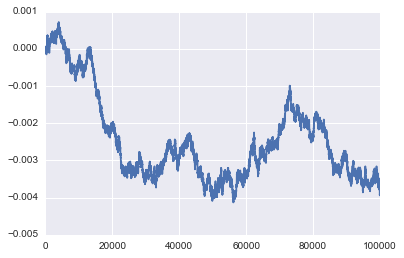

In [16]:
plt.plot(x)

In [17]:
%%timeit
walk(n)

10 loops, best of 3: 91.4 ms per loop


We import the Numba package, and then add the decorator `@jit` immediately before the function definition

In [1]:
from numba import jit, vectorize, float64

In [18]:
@jit(nopython=True)
def step_numba():
    return 1. if random.random() > .5 else -1.

The `nopython=True` argument activates nopython mode, which means that the code is translated directly to machine code, bypassing the CPython interpreter. The nopython mode is faster than python mode, but is more limited and for example lists and dictionaries are not supported. For optimal performance, try to stick with nopython!  

In [19]:
@jit(nopython=True)
def walk_numba(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step_numba()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

In [20]:
%%timeit
walk_numba(n)

The slowest run took 248.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.34 ms per loop


## Mixing in Fortran and C 

* Python and numpy can be too slow for certain tasks
* One can compile external functions and write python wrappers...
* but it's even simpler to directly use Fortran or Cython, hiding away the wrapping! 

In [4]:
!pip install cython fortran-magic

### Fortran

The %%fortran cell magic allows us to write Fortran code into a cell, which gets compiled and imported using f2py.


In [30]:
%%fortran?

In [29]:
%load_ext fortranmagic

/Users/ktw/.local/lib/python2.7/site-packages/IPython/utils/path.py:265: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [22]:
%%fortran
#%%fortran -vvv
#%%fortran -vvv --f90flags='-fopenmp' --extra='-lgomp' # for OpenMP support
subroutine my_function(x, y, z)
    real, intent(in) :: x(:), y(:)
    real, intent(out) :: z(size(x))
    ! using vector operations  
    z(:) = sin(x(:) + y(:))
end subroutine

In [14]:
import numpy as np
x = np.random.normal(size=100)
y = np.random.normal(size=100)
z = my_function(x, y)

### Cython

Cython is a superset of Python which supports calling C functions and declaring C types on variables and class attributes.
Cython allows you to
- wrap C/C++ libraries into Python
- optimize Python code by statically compiling with C


In [31]:
def primes(kmax):  # The argument will be converted to int or raise a TypeError.
    p = []
    result = []  # A Python type
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [32]:
%%timeit
p = primes(100)
#print p

100 loops, best of 3: 2.3 ms per loop


In [70]:
%%cython?

In [24]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [33]:
%%cython
#%%cython --compile-args=-fopenmp --link-args=-fopenmp
def primes_cython(int kmax):  # The argument will be converted to int or raise a TypeError.
    cdef int n, k, i  # These variables are declared with C types.
    cdef int p[1000]  # Another C type
    result = []  # A Python type
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [34]:
%%timeit
p = primes_cython(100)
#print p[-1]

10000 loops, best of 3: 31.6 µs per loop


### Example: the Mandelbrot fractal

In [64]:
import numpy as np

Initialize:

In [65]:
size = 200
iterations = 100

#### Pure python

In [94]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [95]:
%%timeit -n1 -r1 
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1 loop, best of 1: 2.27 s per loop


#### First cython attempt

First just add the cython magic

In [85]:
%%cython
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [90]:
%%timeit -n1 -r1 
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 1.7 s per loop


Insignificant speedup...

#### Second attempt

Now add type information, and use memory views for NumPy arrays

In [98]:
%%cython
import numpy as np

def mandelbrot_cython(int[:,::1] m, 
                      int size, 
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [99]:
%%timeit -n1 -r1 m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 5.33 ms per loop


Huge speedup!

### Other ways to increase performance

We have just scratched the surface. Other powerful methods to increase performance are: 
- **Numexpr** - a package that speeds up complex array operations (sometimes slow in numpy due to creation of many temporary arrays)
- wrapping C libraries with **ctypes**
- **CFFI** (C Foreign Function Interface for Python)